### import libraries

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import SimpleITK as sitk

import matplotlib.pyplot as plt

### read annotations.csv and candidates.csv // paths

In [108]:
data_path = '../dataset/'
TRAIN_IMG_DIR = '../img/train/'
TEST_IMG_DIR = '../img/test/'
IMG_PREF = 'image_'
IMG_EXT = '.jpg'

annot_df = pd.read_csv(data_path + 'CSVFILES/annotations.csv')
cand_df = pd.read_csv(data_path + 'CSVFILES/candidates.csv')
# candv2_df = pd.read_csv('./dataset/CSVFILES/candidates_V2.csv')

### annotations.csv
##### Samples:
<b> 1186 </b> samples

### candidates.csv
##### Samples
<b> 1351 </b> TP in candidates.csv 
|| candidates have <b> 551065 </b> samples


<b> 1557 </b> TP in candidates_V2.csv 
|| candidates_V2 have <b> 754975 </b> samples

### process CT scan

In [6]:
class CT(object):
    def __init__(self, filename = None, coordinates = None):
        self.filename = filename
        self.coordinates = coordinates
        self.itk_img = None
        self.img_arr = None
        
    # Read .mhd/.raw with SimpleITK
    def read_mhd(self):
        path = self.get_mhd_path()
        self.itk_img = sitk.ReadImage(path[0])
        self.img_arr = sitk.GetArrayFromImage(self.itk_img)
         
    def get_mhd_path(self):
        return glob.glob(data_path + '*/' + self.filename + '.mhd')
    
    # Get voxel coordinates
    def get_voxel(self):
        origin = self.get_origin()
        spacing = self.get_spacing()
        coordinates = self.get_coordinates()
        return tuple([np.absolute(coordinates[i] - origin[i]) / spacing[i] for i in range(3)])
    
    def get_coordinates(self):
        return self.coordinates
    
    def get_origin(self):
        return self.itk_img.GetOrigin()
    
    def get_spacing(self):
        return self.itk_img.GetSpacing()
    
    def get_itk_img(self):
        return self.itk_img
    
    def get_image_array(self):
        return self.img_arr

<b> Spacing </b><br> Pixel spacing is measured between the pixel centers <br> and can be different along each dimension

<b> Origin </b><br> The image origin is associated with the coordinates <br> of the first pixel in the image

<b> Voxel </b><br> Voxel coordinates ... <br> ...

In [7]:
pos_ind = cand_df[cand_df['class'] == 1].index # 1351 positives
neg_ind = cand_df[cand_df['class'] == 0].index # 549714 negatives

### undersample negative class

In [8]:
np.random.seed(42)
# Take negative samples only 5 times the size of positive samples
neg_ind = np.random.choice(neg_ind, len(pos_ind) * 5 , replace = False)
selected_cand_df = cand_df.iloc[list(pos_ind) + list(neg_ind)]

# 1351 positive samples (16.66%)
# 6755 negative samples (83.33%)
selected_cand_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8106 entries, 13 to 9679
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   seriesuid  8106 non-null   object 
 1   coordX     8106 non-null   float64
 2   coordY     8106 non-null   float64
 3   coordZ     8106 non-null   float64
 4   class      8106 non-null   int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 380.0+ KB


### split to train test val 

In [13]:
from sklearn.model_selection import train_test_split

X = selected_cand_df.iloc[:, :-1]
y = selected_cand_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42)

<b> Serialize and save data </b>

In [15]:
X_train.to_pickle('./pickle/traindata')
X_val.to_pickle('./pickle/valdata')
X_test.to_pickle('./pickle/testdata')

### get proportions

In [16]:
print('TRAINING DATA')
print('Total examples: ', len(y_train))
print('Total positives: ', y_train.sum())
print(format((y_train.sum() / len(y_train)) * 100, '.2f'), '%')

TRAINING DATA
Total examples:  5187
Total positives:  845
16.29 %


### augment data set

<b> Add all the true positive cases two more times </b>

* DF use .set_index
* Series use .reindex

In [21]:
# Augment X set ----------------------
# 1 pass -----------------------------
# take positives
temp_df = X_train[y_train == 1]
# reindex positives
temp_df = temp_df.set_index(temp_df.index + 1000000)
# add new positives
X_train_aug = X_train.append(temp_df)

# 2 pass -----------------------------
temp_df = X_train[y_train == 1]
temp_df = temp_df.set_index(temp_df.index + 2000000)
X_train_aug = X_train_aug.append(temp_df)


# Augment y set ----------------------
# 1 pass -----------------------------
# take positives
temp_df = X_train[y_train == 1]
# reindex positives
temp_df = y_train.reindex(temp_df.index + 1000000)
# set all series values to 1
temp_df.loc[:] = 1
# add new positives
y_train_aug = y_train.append(temp_df)

# 2 pass -----------------------------
temp_df = X_train[y_train == 1]
temp_df = y_train.reindex(temp_df.index + 2000000)
temp_df.loc[:] = 1
y_train_aug = y_train_aug.append(temp_df)

In [22]:
print('TRAINING DATA')
print('Total examples: ', len(y_train_aug))
print('Total positives: ', y_train_aug.sum())
print(format((y_train_aug.sum() / len(y_train_aug)) * 100, '.2f'), '%')

TRAINING DATA
Total examples:  6877
Total positives:  2535.0
36.86 %


-----

### plot image

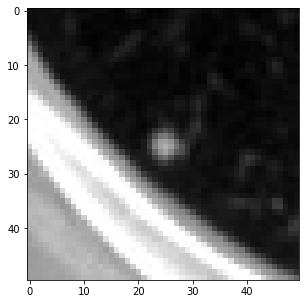

In [25]:
from imageio import imread

plt.figure(figsize = (5, 5))
img = imread(TRAIN_IMG_DIR + IMG_PREF + str(30517) + IMG_EXT)
plt.imshow(img, cmap='gray')

----

### create h5py file with images and classes

In [85]:
import h5py
import PIL

#### train dataset

In [86]:
f = h5py.File('./h5py/malaCADtrain.hdf5', 'w')

# Create classes dataset
f.create_dataset('train_labels', shape = (len(y_train_new),))
f['train_labels'][...] = list(y_train_new)

# Create images dataset
f.create_dataset('train_img', shape = (len(X_train_new), 50, 50))
index = 0
for col in X_train_new.transpose():
    image = PIL.Image.open(TRAIN_IMG_DIR + IMG_PREF + str(col) + IMG_EXT)
    # print(str(index) + ' - ' + str(col) + ' - ' + str(image.size))
    f['train_img'][index, ...] = image
    index += 1
    
f.close()

In [87]:
f = h5py.File('./h5py/malaCADtrain.hdf5', 'r')

input_train = f['train_img'] [...]
label_train = f['train_labels'][...]
f.close()

#### test dataset

In [112]:
f = h5py.File('./h5py/malaCADtest.hdf5', 'w')

# Create classes dataset
f.create_dataset('test_labels', shape = (len(y_test),))
f['test_labels'][...] = list(y_test)

# Create images dataset
f.create_dataset('test_img', shape = (len(X_test), 50, 50))
index = 0
for col in X_test.transpose():
    image = PIL.Image.open(TEST_IMG_DIR + IMG_PREF + str(col) + IMG_EXT)
    # print(str(index) + ' - ' + str(col) + ' - ' + str(image.size))
    f['test_img'][index, ...] = image
    index += 1
    
f.close()

In [113]:
f = h5py.File('./h5py/malaCADtest.hdf5', 'r')

input_test = f['test_img'] [...]
label_test = f['test_labels'][...]
f.close()

----

## create and config model

In [100]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam

In [92]:
# Model configuration
batch_size = 50
img_width, img_height, img_num_channels = 50, 50, 1
loss_function = sparse_categorical_crossentropy
no_classes = 2
no_epochs = 5
optimizer = Adam()
validation_split = 0.2
verbosity = 1

In [114]:
# Reshape data
input_train = input_train.reshape(len(input_train), img_width, img_height, img_num_channels)
input_test = input_test.reshape(len(input_test), img_width, img_height, img_num_channels)

input_shape = (img_width, img_height, img_num_channels)

In [96]:
# Create the model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape = input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(no_classes, activation='softmax'))

# Compile the model
model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])

# Display a model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 247808)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               31719552  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 31,812,482
Trainable params: 31,812,482
Non-trainable params: 0
__________________________________________

### fit model

In [97]:
# Fit data to model
history = model.fit(input_train, label_train,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_split=validation_split)

Train on 5501 samples, validate on 1376 samples
Epoch 1/5
5501/5501 [==============================] - 62s 11ms/sample - loss: 31.2617 - accuracy: 0.7853 - val_loss: 1.3232 - val_accuracy: 0.3358
Epoch 2/5
5501/5501 [==============================] - 62s 11ms/sample - loss: 0.4346 - accuracy: 0.8355 - val_loss: 1.0953 - val_accuracy: 0.4608
Epoch 3/5
5501/5501 [==============================] - 61s 11ms/sample - loss: 0.3490 - accuracy: 0.8671 - val_loss: 1.3542 - val_accuracy: 0.3118
Epoch 4/5
5501/5501 [==============================] - 61s 11ms/sample - loss: 0.3121 - accuracy: 0.8740 - val_loss: 1.0675 - val_accuracy: 0.4804
Epoch 5/5
5501/5501 [==============================] - 63s 11ms/sample - loss: 0.2534 - accuracy: 0.9044 - val_loss: 1.5436 - val_accuracy: 0.4092


In [99]:
model.save('first_cnn_model.h5')

### predict

In [115]:
score = model.evaluate(input_test, label_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.42157794408380767 / Test accuracy: 0.8569667339324951


In [117]:
preds = model.predict_classes(input_test)

In [118]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(label_test, preds))
print(classification_report(label_test, preds))

[[1269   71]
 [ 161  121]]
              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92      1340
         1.0       0.63      0.43      0.51       282

    accuracy                           0.86      1622
   macro avg       0.76      0.69      0.71      1622
weighted avg       0.84      0.86      0.85      1622



---
## 2nd pass

In [119]:
# Model configuration
batch_size = 50
img_width, img_height, img_num_channels = 50, 50, 1
loss_function = sparse_categorical_crossentropy
no_classes = 2
no_epochs = 20
optimizer = Adam()
validation_split = 0.2
verbosity = 1

# Fit data to model
history = model.fit(input_train, label_train,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_split=validation_split)

Train on 5501 samples, validate on 1376 samples
Epoch 1/20
5501/5501 [==============================] - 61s 11ms/sample - loss: 0.1803 - accuracy: 0.9318 - val_loss: 1.4949 - val_accuracy: 0.5581
Epoch 2/20
5501/5501 [==============================] - 61s 11ms/sample - loss: 0.1399 - accuracy: 0.9484 - val_loss: 1.9399 - val_accuracy: 0.5603
Epoch 3/20
5501/5501 [==============================] - 62s 11ms/sample - loss: 0.0765 - accuracy: 0.9738 - val_loss: 2.5228 - val_accuracy: 0.5683
Epoch 4/20
5501/5501 [==============================] - 61s 11ms/sample - loss: 0.0416 - accuracy: 0.9869 - val_loss: 4.0340 - val_accuracy: 0.5007
Epoch 5/20
5501/5501 [==============================] - 61s 11ms/sample - loss: 0.0346 - accuracy: 0.9895 - val_loss: 3.5961 - val_accuracy: 0.5472
Epoch 6/20
5501/5501 [==============================] - 62s 11ms/sample - loss: 0.0524 - accuracy: 0.9805 - val_loss: 5.0075 - val_accuracy: 0.5131
Epoch 7/20
5501/5501 [==============================] - 62s 11ms

In [120]:
score = model.evaluate(input_test, label_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 1.781258276152699 / Test accuracy: 0.8520345091819763


In [121]:
preds = model.predict_classes(input_test)
print(confusion_matrix(label_test, preds))
print(classification_report(label_test, preds))

[[1227  113]
 [ 127  155]]
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.91      1340
         1.0       0.58      0.55      0.56       282

    accuracy                           0.85      1622
   macro avg       0.74      0.73      0.74      1622
weighted avg       0.85      0.85      0.85      1622



## 3rd pass - less negatives

In [ ]:
f = h5py.File('./h5py/malaCADtrain2nd.hdf5', 'w')

# Create classes dataset
f.create_dataset('train_labels', shape = (len(y_train_new),))
f['train_labels'][...] = list(y_train_new)

# Create images dataset
f.create_dataset('train_img', shape = (len(X_train_new), 50, 50))
index = 0
for col in X_train_new.transpose():
    image = PIL.Image.open(TRAIN_IMG_DIR + IMG_PREF + str(col) + IMG_EXT)
    # print(str(index) + ' - ' + str(col) + ' - ' + str(image.size))
    f['train_img'][index, ...] = image
    index += 1
    
f.close()


f = h5py.File('./h5py/malaCADtrain2nd.hdf5', 'r')
input_train = f['train_img'] [...]
label_train = f['train_labels'][...]
f.close()


# ---------------------------------------------------------------------
f = h5py.File('./h5py/malaCADtest2nd.hdf5', 'w')

# Create classes dataset
f.create_dataset('test_labels', shape = (len(y_test),))
f['test_labels'][...] = list(y_test)

# Create images dataset
f.create_dataset('test_img', shape = (len(X_test), 50, 50))
index = 0
for col in X_test.transpose():
    image = PIL.Image.open(TEST_IMG_DIR + IMG_PREF + str(col) + IMG_EXT)
    # print(str(index) + ' - ' + str(col) + ' - ' + str(image.size))
    f['test_img'][index, ...] = image
    index += 1
    
f.close()


f = h5py.File('./h5py/malaCADtest2nd.hdf5', 'r')
input_test = f['test_img'] [...]
label_test = f['test_labels'][...]
f.close()